In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import sympy as sy
import simtk.unit as unit
from simtk import openmm as mm
from simtk.openmm import app
import skopt as skopt
from tqdm import tqdm

# 2D Lennard-Jones fluid

In [2]:
n_particles = 100
reduced_density = 0.75
mass = 39.948 * unit.amu
sigma = 3.404 * unit.angstroms
epsilon = 0.238 * unit.kilocalories_per_mole
charge = 0.0 * unit.elementary_charge

In [3]:
temperature = 300.0 * unit.kelvin
integration_timestep = 0.01 * unit.picoseconds # 2 Ar particles small oscillations period: 1.27 ps
collisions_rate = 1.0 / unit.picoseconds

equilibration_time = 0.5 * unit.nanoseconds
production_time = 1.0 * unit.nanoseconds
saving_time = 10.0 * unit.picoseconds

equilibration_n_steps = round(equilibration_time/integration_timestep)

In [4]:
radius = 2.0**(-5/6) * sigma
print(radius)

1.9104304062225528 A


In [5]:
area_particles = n_particles*np.pi*radius**2
area = area_particles/reduced_density
l_box = area**(1/2)
height = 4*radius
print('Side of the box: {}'.format(l_box))
print('Height of the box: {}'.format(height))

Side of the box: 39.09988916721195 A
Height of the box: 7.641721624890211 A


In [32]:
space = skopt.Space([[0.0, l_box._value], [0.0, l_box._value]])
generator = skopt.sampler.Grid(use_full_layout=False)
#generator = skopt.sampler.Lhs(criterion="maximin", iterations=10000)
initial_positions = generator.generate(space.dimensions, n_particles)
initial_positions = np.array(initial_positions)*unit.angstroms

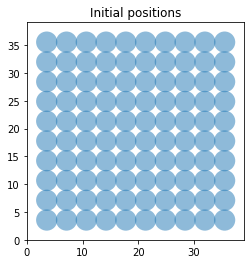

In [33]:
ax = plt.subplot(aspect='equal')

patches=[]
for ii in range(n_particles):
    patches.append(Circle(initial_positions[ii,:]._value, radius._value))

p = PatchCollection(patches, alpha=0.5)
ax.add_collection(p)

ax.set_title("Initial positions")
ax.set_xlim([0.0, l_box._value])
ax.set_ylim([0.0, l_box._value])
plt.show()

In [34]:
system = mm.System()

In [35]:
v1 = np.zeros(3) * unit.angstroms
v2 = np.zeros(3) * unit.angstroms
v3 = np.zeros(3) * unit.angstroms

v1[0] = l_box
v2[1] = l_box
v3[2] = height

system.setDefaultPeriodicBoxVectors(v1, v2, v3)

In [36]:
non_bonded_force = mm.NonbondedForce()
non_bonded_force.setNonbondedMethod(mm.NonbondedForce.CutoffPeriodic)
non_bonded_force.setCutoffDistance(3.0*sigma)
non_bonded_force.setUseSwitchingFunction(True)
non_bonded_force.setSwitchingDistance(2.0*sigma)
non_bonded_force.setUseDispersionCorrection(True)

In [37]:
for _ in range(n_particles):
    system.addParticle(mass)
    non_bonded_force.addParticle(charge, sigma, epsilon)

In [38]:
_ = system.addForce(non_bonded_force)